In [1]:
import numpy as np
import pandas as pd
import os
from pathlib import Path
import glob
import sys
import os
sys.path.append(os.path.abspath("../.."))
from src.training.loss_functions import covariance_loss

# Define the configurations from your ablation study (templates - will be filled with seeds)
ablation_configs = [
    {
        'name': 'Full Model',
        'folder_template': 's1_ep35_lr5_la1_seed{seed}_ldim2_s2_lr6_la4_lc1_lcon8'
    },
    {
        'name': 'No Adversarial',
        'folder_template': 's1_ep35_lr5_la0_seed{seed}_ldim2_s2_lr6_la0_lc1_lcon8'
    },
    {
        'name': 'No Covariance',
        'folder_template': 's1_ep35_lr5_la1_seed{seed}_ldim2_s2_lr6_la4_lc0_lcon8'
    },
    {
        'name': 'No Contrastive',
        'folder_template': 's1_ep35_lr5_la1_seed{seed}_ldim2_s2_lr6_la4_lc1_lcon0'
    },
    {
        'name': 'Reconstruction Only',
        'folder_template': 's1_ep35_lr5_la0_seed{seed}_ldim2_s2_lr6_la0_lc0_lcon0'
    }
]

# Define seeds to analyze
seeds = [42, 43, 44]

print("🔍 Checking for ablation study results...")
results_dir = Path("../../results")
print(f"Results directory: {results_dir.absolute()}")
print(f"Directory exists: {results_dir.exists()}")

# List all available result folders
if results_dir.exists():
    all_folders = [f.name for f in results_dir.iterdir() if f.is_dir()]
    print(f"\nFound {len(all_folders)} result folders:")
    for folder in sorted(all_folders):
        print(f"  - {folder}")
        
    # Check which seed combinations exist
    print(f"\n🌱 Checking availability for seeds {seeds}:")
    for config in ablation_configs:
        print(f"\n{config['name']}:")
        for seed in seeds:
            folder_name = config['folder_template'].format(seed=seed)
            exists = folder_name in all_folders
            status = "✅" if exists else "❌"
            print(f"  Seed {seed}: {status} {folder_name}")
else:
    print("❌ Results directory not found!")


🔍 Checking for ablation study results...
Results directory: /Users/inescunha/Documents/GitHub/AI4CellFate/notebooks/manuscript/../../results
Directory exists: True

Found 101 result folders:
  - cross_validation
  - data_size_study0.1_s1_ep35_lr5_la1_seed42_ldim2_s2_lr6_la4_lc1_lcon8
  - data_size_study0.1_s1_ep35_lr5_la1_seed43_ldim2_s2_lr6_la4_lc1_lcon8
  - data_size_study0.1_s1_ep35_lr5_la1_seed44_ldim2_s2_lr6_la4_lc1_lcon8
  - data_size_study0.2_s1_ep35_lr5_la1_seed42_ldim2_s2_lr6_la4_lc1_lcon8
  - data_size_study0.2_s1_ep35_lr5_la1_seed43_ldim2_s2_lr6_la4_lc1_lcon8
  - data_size_study0.2_s1_ep35_lr5_la1_seed44_ldim2_s2_lr6_la4_lc1_lcon8
  - data_size_study0.3_s1_ep35_lr5_la1_seed42_ldim2_s2_lr6_la4_lc1_lcon8
  - data_size_study0.3_s1_ep35_lr5_la1_seed43_ldim2_s2_lr6_la4_lc1_lcon8
  - data_size_study0.3_s1_ep35_lr5_la1_seed44_ldim2_s2_lr6_la4_lc1_lcon8
  - data_size_study0.4_s1_ep35_lr5_la1_seed42_ldim2_s2_lr6_la4_lc1_lcon8
  - data_size_study0.4_s1_ep35_lr5_la1_seed43_ldim2_s2_lr6

In [2]:
def load_metrics_from_folder(folder_path, verbose=True):
    """
    Load all metrics from a specific ablation study folder.
    
    Returns:
        dict: Dictionary containing all extracted metrics
    """
    metrics = {
        'avg_kl_divergence': None,
        'feature_correlation': None,
        'feature_covariance': None,
        'accuracy': None,
        'precision': None,
        'folder_found': False,
        'files_found': []
    }
    
    if not folder_path.exists():
        if verbose:
            print(f"❌ Folder not found: {folder_path}")
        return metrics
    
    metrics['folder_found'] = True
    if verbose:
        print(f"📂 Processing folder: {folder_path.name}")
    
    # Find all .npy files in the folder
    npy_files = list(folder_path.glob("*.npy"))
    metrics['files_found'] = [f.name for f in npy_files]
    
    if not npy_files:
        if verbose:
            print("   ❌ No .npy files found")
        return metrics
    
    if verbose:
        print(f"   Found {len(npy_files)} .npy files")
    
    # Load KL divergences
    kl_files = [f for f in npy_files if 'kl_divergences_epoch' in f.name]
    if kl_files:
        kl_file = kl_files[0]
        kl_divergences = np.load(kl_file)
        metrics['avg_kl_divergence'] = np.mean(kl_divergences)
        if verbose:
            print(f"   ✅ KL Divergences: {kl_divergences} (avg: {metrics['avg_kl_divergence']:.4f})")
    elif verbose:
        print("   ❌ KL divergence file not found")
    
    # Load correlation matrix
    corr_files = [f for f in npy_files if 'correlation_matrix_epoch' in f.name]
    if corr_files:
        corr_file = corr_files[0]
        corr_matrix = np.load(corr_file)
        # Get off-diagonal correlation (for 2D latent space, this is [0,1] or [1,0])
        if corr_matrix.shape == (2, 2):
            metrics['feature_correlation'] = abs(corr_matrix[0, 1])  # Absolute correlation
        else:
            # For higher dimensions, take mean absolute off-diagonal correlation
            off_diag_mask = ~np.eye(corr_matrix.shape[0], dtype=bool)
            metrics['feature_correlation'] = np.mean(np.abs(corr_matrix[off_diag_mask]))
        if verbose:
            print(f"   ✅ Feature correlation: {metrics['feature_correlation']:.4f}")
    elif verbose:
        print("   ❌ Correlation matrix file not found")
    
    # Load covariance matrix
    cov_files = [f for f in npy_files if 'covariance_matrix_epoch' in f.name]
    if cov_files:
        cov_file = cov_files[0]
        cov_matrix = np.load(cov_file)
        # Get off-diagonal covariance (for 2D latent space, this is [0,1] or [1,0])
        if cov_matrix.shape == (2, 2):
            metrics['feature_covariance'] = covariance_loss(cov_matrix)[1]
            #metrics['feature_covariance'] = 2*abs(cov_matrix[0, 1]) / (abs(cov_matrix[0,0] + abs(cov_matrix[1, 1])))#+ abs(cov_matrix[1, 0]) # Absolute covariance
        else:
            # For higher dimensions, take mean absolute off-diagonal covariance
            off_diag_mask = ~np.eye(cov_matrix.shape[0], dtype=bool)
            metrics['feature_covariance'] = np.mean(np.abs(cov_matrix[off_diag_mask]))
        if verbose:
            print(f"   ✅ Feature covariance: {metrics['feature_covariance']:.4f}")
    elif verbose:
        print("   ❌ Covariance matrix file not found")
    
    # Load confusion matrix and calculate accuracy
    cm_files = [f for f in npy_files if 'confusion_matrix_values_epoch' in f.name]
    if cm_files:
        cm_file = cm_files[0]
        conf_matrix_normalized = np.load(cm_file)
        
        # Calculate metrics from confusion matrix
        metrics['accuracy'] = np.mean(np.diag(conf_matrix_normalized))  # Mean diagonal (accuracy)
        
        # Precision (class 0)
        if conf_matrix_normalized[0,0] + conf_matrix_normalized[1,0] > 0:
            metrics['precision'] = conf_matrix_normalized[0,0] / (conf_matrix_normalized[0,0] + conf_matrix_normalized[1,0])
        
        if verbose:
            print(f"   ✅ Accuracy: {metrics['accuracy']:.4f}")
            print(f"   ✅ Precision: {metrics['precision']:.4f}")
    elif verbose:
        print("   ❌ Confusion matrix file not found")
    
    if verbose:
        print()
    return metrics

# Test the function with one folder first
print("🧪 Testing metric loading function...")
test_config = ablation_configs[1]  # Full Model
test_folder = results_dir / test_config['folder_template'].format(seed=42)
test_metrics = load_metrics_from_folder(test_folder)


🧪 Testing metric loading function...
📂 Processing folder: s1_ep35_lr5_la0_seed42_ldim2_s2_lr6_la0_lc1_lcon8
   Found 4 .npy files
   ✅ KL Divergences: [0.20198056 0.09056863] (avg: 0.1463)
   ✅ Feature correlation: 0.7401
   ✅ Feature covariance: 0.1547
   ✅ Accuracy: 0.7312
   ✅ Precision: 0.7431



In [3]:
# Load metrics for all configurations across all seeds
print("📊 Loading metrics for all ablation configurations across seeds...")
print("="*80)

all_metrics = {}

for config in ablation_configs:
    print(f"\n🔄 Processing: {config['name']}")
    config_metrics = {
        'avg_kl_divergence': [],
        'feature_correlation': [],
        'feature_covariance': [],
        'accuracy': [],
        'precision': [],
        'seeds_found': []
    }
    
    for seed in seeds:
        folder_name = config['folder_template'].format(seed=seed)
        folder_path = results_dir / folder_name
        
        print(f"   🌱 Seed {seed}: ", end="")
        metrics = load_metrics_from_folder(folder_path, verbose=False)
        
        if metrics['folder_found']:
            print("✅ Found")
            config_metrics['seeds_found'].append(seed)
            
            # Collect metrics
            if metrics['avg_kl_divergence'] is not None:
                config_metrics['avg_kl_divergence'].append(metrics['avg_kl_divergence'])
            if metrics['feature_correlation'] is not None:
                config_metrics['feature_correlation'].append(metrics['feature_correlation'])
            if metrics['feature_covariance'] is not None:
                config_metrics['feature_covariance'].append(metrics['feature_covariance'])
            if metrics['accuracy'] is not None:
                config_metrics['accuracy'].append(metrics['accuracy'])
            if metrics['precision'] is not None:
                config_metrics['precision'].append(metrics['precision'])
        else:
            print("❌ Missing")
    
    all_metrics[config['name']] = config_metrics
    
    # Print summary for this config
    n_seeds = len(config_metrics['seeds_found'])
    print(f"   📈 Summary: {n_seeds}/{len(seeds)} seeds found")
    if n_seeds > 0:
        for metric_name in ['avg_kl_divergence', 'feature_correlation', 'feature_covariance', 'accuracy', 'precision']:
            values = config_metrics[metric_name]
            if values:
                mean_val = np.mean(values)
                std_val = np.std(values, ddof=1) if len(values) > 1 else 0
                print(f"     - {metric_name}: {mean_val:.4f} ± {std_val:.4f} (n={len(values)})")
    print("-" * 60)

print("\n✅ Metric loading completed!")


📊 Loading metrics for all ablation configurations across seeds...

🔄 Processing: Full Model
   🌱 Seed 42: ✅ Found
   🌱 Seed 43: ✅ Found
   🌱 Seed 44: ✅ Found
   📈 Summary: 3/3 seeds found
     - avg_kl_divergence: 0.2573 ± 0.2593 (n=3)
     - feature_correlation: 0.1670 ± 0.0509 (n=3)
     - feature_covariance: 0.1403 ± 0.0201 (n=3)
     - accuracy: 0.7177 ± 0.0042 (n=3)
     - precision: 0.7187 ± 0.0150 (n=3)
------------------------------------------------------------

🔄 Processing: No Adversarial
   🌱 Seed 42: ✅ Found
   🌱 Seed 43: ✅ Found
   🌱 Seed 44: ✅ Found
   📈 Summary: 3/3 seeds found
     - avg_kl_divergence: 0.2990 ± 0.2101 (n=3)
     - feature_correlation: 0.4332 ± 0.3346 (n=3)
     - feature_covariance: 0.0987 ± 0.0486 (n=3)
     - accuracy: 0.7004 ± 0.0378 (n=3)
     - precision: 0.7277 ± 0.0179 (n=3)
------------------------------------------------------------

🔄 Processing: No Covariance
   🌱 Seed 42: ✅ Found
   🌱 Seed 43: ✅ Found
   🌱 Seed 44: ✅ Found
   📈 Summary: 3/3

In [4]:
# Create the ablation study table with mean ± std across seeds
print("📋 Creating Ablation Study Table (Mean ± Std across seeds)...")
print("="*70)

def format_mean_std(values_list):
    """Format mean ± std for a list of values."""
    if not values_list:
        return "N/A"
    
    mean_val = np.mean(values_list)
    if len(values_list) > 1:
        std_val = np.std(values_list, ddof=1)
        return f"{mean_val:.3f} ± {std_val:.3f}"
    else:
        return f"{mean_val:.3f} ± 0.000"

# Prepare data for the table
table_data = {
    'Metric': [
        'Average KL Divergence',
        'Feature Correlation (|r|)',
        'Feature Covariance (|cov|)',
        'Classification Accuracy',
        'Precision (Class 0)'
    ]
}

# Add columns for each configuration
for config_name in [config['name'] for config in ablation_configs]:
    config_metrics = all_metrics[config_name]
    
    column_values = [
        format_mean_std(config_metrics['avg_kl_divergence']),
        format_mean_std(config_metrics['feature_correlation']),
        format_mean_std(config_metrics['feature_covariance']),
        format_mean_std(config_metrics['accuracy']),
        format_mean_std(config_metrics['precision'])
    ]
    
    table_data[config_name] = column_values

# Create DataFrame
df_ablation = pd.DataFrame(table_data)

# Display the table
print("🎯 ABLATION STUDY RESULTS TABLE (Mean ± Std)")
print("="*100)
print(df_ablation.to_string(index=False))
print("="*100)

# Also save as CSV for manuscript
# csv_path = "../../results/ablation_study_table_mean_std.csv"
# df_ablation.to_csv(csv_path, index=False)
# print(f"\n💾 Table saved as CSV: {csv_path}")

# Display sample sizes for each configuration
print("\n📊 SAMPLE SIZES (Number of seeds with data):")
print("="*60)
for config_name in [config['name'] for config in ablation_configs]:
    config_metrics = all_metrics[config_name]
    n_seeds = len(config_metrics['seeds_found'])
    seeds_list = config_metrics['seeds_found']
    print(f"{config_name}: {n_seeds}/{len(seeds)} seeds {seeds_list}")


📋 Creating Ablation Study Table (Mean ± Std across seeds)...
🎯 ABLATION STUDY RESULTS TABLE (Mean ± Std)
                    Metric    Full Model No Adversarial No Covariance No Contrastive Reconstruction Only
     Average KL Divergence 0.257 ± 0.259  0.299 ± 0.210 0.328 ± 0.203  1.024 ± 0.378       0.226 ± 0.036
 Feature Correlation (|r|) 0.167 ± 0.051  0.433 ± 0.335 0.089 ± 0.023  0.223 ± 0.026       0.185 ± 0.033
Feature Covariance (|cov|) 0.140 ± 0.020  0.099 ± 0.049 0.253 ± 0.061  0.062 ± 0.012       1.182 ± 0.308
   Classification Accuracy 0.718 ± 0.004  0.700 ± 0.038 0.701 ± 0.025  0.564 ± 0.090       0.617 ± 0.020
       Precision (Class 0) 0.719 ± 0.015  0.728 ± 0.018 0.712 ± 0.010  0.566 ± 0.094       0.620 ± 0.022

📊 SAMPLE SIZES (Number of seeds with data):
Full Model: 3/3 seeds [42, 43, 44]
No Adversarial: 3/3 seeds [42, 43, 44]
No Covariance: 3/3 seeds [42, 43, 44]
No Contrastive: 3/3 seeds [42, 43, 44]
Reconstruction Only: 3/3 seeds [42, 43, 44]


🎨 Creating final discrete color heatmap with axis labels...


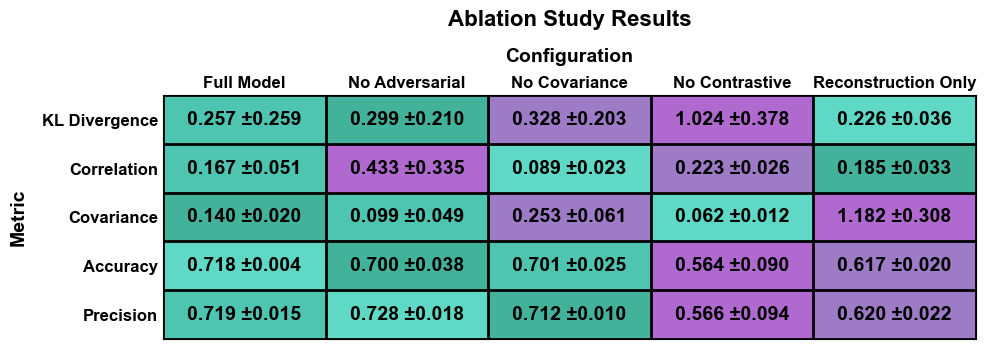

In [13]:
# FINAL DISCRETE COLOR HEATMAP - With axis labels and larger text
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap
import pandas as pd

print("🎨 Creating final discrete color heatmap with axis labels...")

# Use the existing all_metrics data that was already loaded
configs_order = ['Full Model', 'No Adversarial', 'No Covariance', 'No Contrastive', 'Reconstruction Only']
available_configs = [config for config in configs_order if config in all_metrics and len(all_metrics[config]['seeds_found']) > 0]

# Calculate mean and std for each metric using existing data
summary_data = {}
for config in available_configs:
    summary_data[config] = {}
    config_metrics = all_metrics[config]
    
    for metric in ['avg_kl_divergence', 'feature_correlation', 'feature_covariance', 'accuracy', 'precision']:
        values = config_metrics[metric]
        if values:
            summary_data[config][f'{metric}_mean'] = np.mean(values)
            summary_data[config][f'{metric}_std'] = np.std(values, ddof=1) if len(values) > 1 else 0
        else:
            summary_data[config][f'{metric}_mean'] = np.nan
            summary_data[config][f'{metric}_std'] = np.nan

# Create matrices for visualization
metric_names = ['KL Divergence', 'Correlation', 'Covariance', 'Accuracy', 'Precision']
metric_keys = ['avg_kl_divergence', 'feature_correlation', 'feature_covariance', 'accuracy', 'precision']

# Create data matrix (will contain rank values 0-4) and text matrix
rank_matrix = np.zeros((len(metric_names), len(available_configs)), dtype=int)
text_matrix = np.empty((len(metric_names), len(available_configs)), dtype=object)

for i, (metric_name, metric_key) in enumerate(zip(metric_names, metric_keys)):
    values = []
    texts = []
    
    for j, config in enumerate(available_configs):
        mean_val = summary_data[config][f'{metric_key}_mean']
        std_val = summary_data[config][f'{metric_key}_std']
        
        if not np.isnan(mean_val):
            values.append(mean_val)
            texts.append(f"{mean_val:.3f} ±{std_val:.3f}")
        else:
            values.append(np.nan)
            texts.append("N/A")
    
    # Assign ranks based on performance
    if len(values) > 1 and not all(np.isnan(v) for v in values):
        values = np.array(values)
        valid_mask = ~np.isnan(values)
        
        if np.sum(valid_mask) > 1:
            valid_values = values[valid_mask]
            
            # For metrics where lower is better, rank by ascending order
            if metric_key in ['avg_kl_divergence', 'feature_correlation', 'feature_covariance']:
                sorted_indices = np.argsort(valid_values)  # Lower is better
            else:
                sorted_indices = np.argsort(valid_values)[::-1]  # Higher is better
            
            # Assign ranks: 0=best, 1=2nd best, 2=3rd best, 3=2nd worst, 4=worst
            ranks = np.full(len(valid_values), -1, dtype=int)
            ranks[sorted_indices] = np.arange(len(sorted_indices))
            
            # Map to color indices (0=best=green, 4=worst=red)
            color_indices = np.zeros(len(available_configs), dtype=int)
            color_indices[valid_mask] = ranks
            color_indices[~valid_mask] = -1  # Invalid data
            
            rank_matrix[i, :] = color_indices
    
    # Set text matrix
    for j, text in enumerate(texts):
        text_matrix[i, j] = text

# Define discrete pastel colors for each rank (more pastel like before)
# 0=Best (Pastel Green), 1=2nd Best (Light Green), 2=3rd (Green-ish), 3=2nd Worst (Orange), 4=Worst (Light Pink)
discrete_colors = [
    'turquoise',  # 0: Best 
    'turquoise',  # 1: 2nd Best
    'turquoise',  # 2: 3rd
    '#9C27B0',  # 3: 2nd Worst
    '#9C27B0'   # 4: Worst 
]
discrete_colors = ["#1ED5C0", "#19BDA9", "#149E8E", "#7C56B2", "#9C27B0"]

from matplotlib.colors import to_rgb

def lighten(hex_color, factor=0.7):
    # factor in (0,1); closer to 1 → lighter
    r,g,b = to_rgb(hex_color)
    r = 1 - (1 - r)*factor
    g = 1 - (1 - g)*factor
    b = 1 - (1 - b)*factor
    return (r,g,b)

# Your discrete palette (turquoise → purple)
colors = ["#1ABC9C", "#17A589", "#149174", "#7C56B2", "#9C27B0"]
# Lighter versions (tweak factor to taste, e.g., 0.65–0.8)
discrete_colors = [lighten(c, 0.7) for c in colors]
discrete_colors = ["#5FD9C5", "#4EC5B1", "#43B29B", "#9D7BC6", "#B06ACF"]
# Create custom colormap for discrete ranks
discrete_cmap = ListedColormap(discrete_colors) #"magma_r"#
# Set Arial font
plt.rcParams['font.family'] = 'Arial'

# Create the plot
fig, ax = plt.subplots(figsize=(10, 7))

# Create the heatmap using discrete colors
im = ax.imshow(rank_matrix, cmap=discrete_cmap, vmin=0, vmax=4, aspect=0.3)

# Add text annotations
for i in range(len(metric_names)):
    for j in range(len(available_configs)):
        text = text_matrix[i, j]
        # Use black text for all pastel colors (they're all light enough)
        rank = rank_matrix[i, j]
        text_color = 'black'  # Black text for all pastel colors
        
        ax.text(j, i, text, ha='center', va='center', 
                fontsize=14, fontweight='bold', color=text_color, family='Arial')

# Customize the plot with LARGER text and axis labels
ax.set_xticks(range(len(available_configs)))
ax.set_yticks(range(len(metric_names)))
ax.set_xticklabels(available_configs, fontweight='bold', fontsize=12, ha='center', family='Arial')
ax.set_yticklabels(metric_names, fontweight='bold', fontsize=12, family='Arial')

# Move x-axis labels to top
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')

# Add axis labels at the top left
ax.set_xlabel('Configuration', fontweight='bold', fontsize=14, family='Arial', labelpad=10)
ax.set_ylabel('Metric', fontweight='bold', fontsize=14, family='Arial', labelpad=10)

# Position the labels properly (xlabel at top, ylabel at left)
ax.xaxis.set_label_position('top')
ax.yaxis.set_label_position('left')

# Add title
ax.set_title('Ablation Study Results', 
             fontsize=16, fontweight='bold', pad=50, family='Arial')

# Remove tick marks
ax.tick_params(length=0)

# Add grid lines
for i in range(len(metric_names) + 1):
    ax.axhline(i - 0.5, color='black', linewidth=2)
for j in range(len(available_configs) + 1):
    ax.axvline(j - 0.5, color='black', linewidth=2)

# cmap_good_bad = LinearSegmentedColormap.from_list(
#     'good_bad', ['#1ABC9C', '#9C27B0'], N=256
# )


# cbar.set_ticks([0.05, 0.95])
# cbar.set_ticklabels(['good', 'bad'])
# cbar.ax.tick_params(labelsize=12)

# # Add colorbar to the plot
# cbar = plt.colorbar(im, ax=ax, shrink=0.6, aspect=15)
# cbar.set_label('Relative Performance\n(within each metric)', fontweight='bold', fontsize=12, family='Arial')
# cbar.ax.tick_params(labelsize=11)

plt.tight_layout()

# Save the plot
#plt.savefig("ablation_study_heatmap_FINAL.eps", format="eps", dpi=300, bbox_inches='tight', facecolor='white')

plt.show()

